# House Price Prediction

* In this algorithm we are predicting the suburbs located in boston, With 506 entries of data and aggregate of 14 features of homes are fed in for training and testing and is expected to predict the house prince range with price units in 1000 dollars as unit.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

Importing the Boston House Price Dataset

In [2]:
import pandas as pd
import numpy as np

# URL for the original Boston dataset
data_url = "http://lib.stat.cmu.edu/datasets/boston"

# Read the dataset
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)

# Split the data into features and target
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])  # Features
target = raw_df.values[1::2, 2]  # Target values

# Column names for the features (reconstructing similar to original `load_boston`)
feature_names = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
    "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]

# Description of the dataset
description = """
The Boston housing dataset is a regression dataset that was originally included in scikit-learn.
It has been removed due to ethical concerns. It contains 506 instances and 13 features related to housing prices.
"""

# Creating a dictionary like `load_boston`
house_price_dataset = {
    "data": pd.DataFrame(data, columns=feature_names),  # Features as a DataFrame
    "target": pd.Series(target, name="Target"),         # Target as a Series
    "feature_names": feature_names,                    # List of feature names
    "DESCR": description                               # Dataset description
}

# Combine into a single DataFrame for convenience
df = pd.concat([house_price_dataset["data"], house_price_dataset["target"]], axis=1)

# Display the first few rows
print(df.head())


      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  Target  
0     15.3  396.90   4.98    24.0  
1     17.8  396.90   9.14    21.6  
2     17.8  392.83   4.03    34.7  
3     18.7  394.63   2.94    33.4  
4     18.7  396.90   5.33    36.2  


In [3]:
df.shape

(506, 14)

In [4]:
# Check for the missing values
df.isnull().sum()

,0
CRIM,0
ZN,0
INDUS,0
CHAS,0
NOX,0
RM,0
AGE,0
DIS,0
RAD,0
TAX,0


In [5]:
!pip install sweetviz


In [6]:
import sweetviz as sv
an = sv.analyze(df)
an.show_html('/.report_html')

                                             |          | [  0%]   00:00 -> (? left)

Report /.report_html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [7]:
correlation = df.corr()

<Axes: >

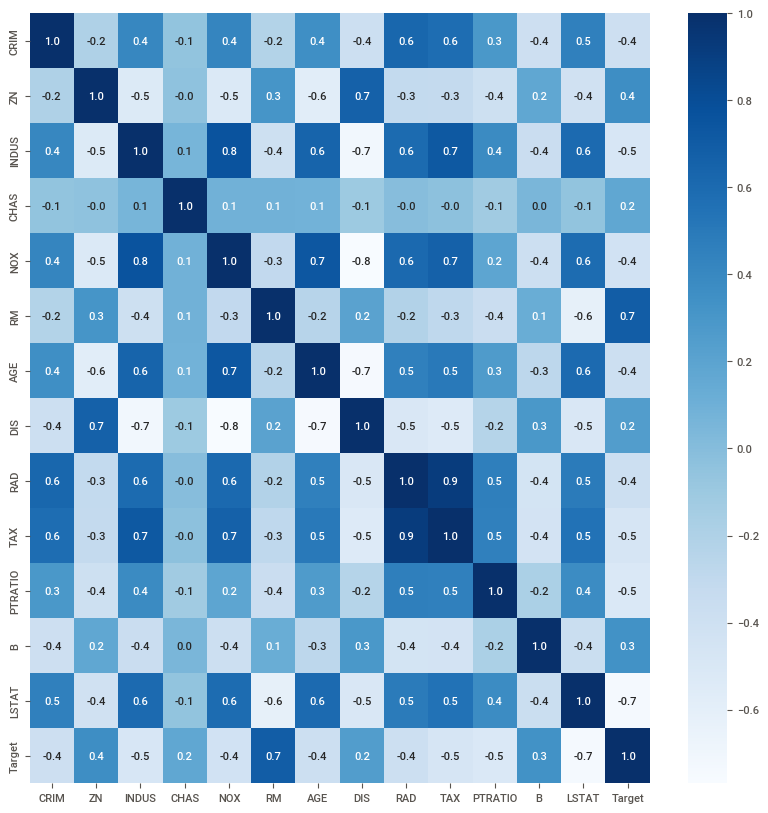

In [8]:
# Constructing a heatmap to understand the correlation
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True,fmt = '.1f',annot=True,annot_kws={'size':8}, cmap='Blues')

In [9]:
 df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Splitting the data and the target

In [10]:
X = df.drop(['Target'],axis=1)
y = df['Target']

In [11]:
print(X)
print(y)

        CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.98  
1       17.8  396.90   9.14  
2       1

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [13]:
X_train.shape

(404, 13)

In [14]:
X_test.shape

(102, 13)

Model Training
1. XGBoost Regressor



In [15]:
model = XGBRegressor()

In [16]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# For Training Data

In [24]:
y_pred = model.predict(X_train)

In [33]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print("the acccuracy of this r2 score method with the prediction value is",r2_score(y_train,y_pred))
print("the accuracy of this mean absolute error with the prediction value is",mean_absolute_error(y_train,y_pred))

the acccuracy of this r2 score method with the prediction value is 0.9999980039471451
the accuracy of this mean absolute error with the prediction value is 0.0091330346494618


# For Testing Data

In [35]:
model.fit(X_train,y_train)
y_pred1 = model.predict(X_test)
print("the accuracy of r2 metrics score is",r2_score(y_test,y_pred1))
print("The accuracy of the mean_absolute_error is",mean_absolute_error(y_test,y_pred1))

the accuracy of r2 metrics score is 0.9051721149855378
The accuracy of the mean_absolute_error is 2.0748727686264927


# Visualizing the actual prices and visualization

Text(0.5, 1.0, 'The Actual Price vs Predicted Price')

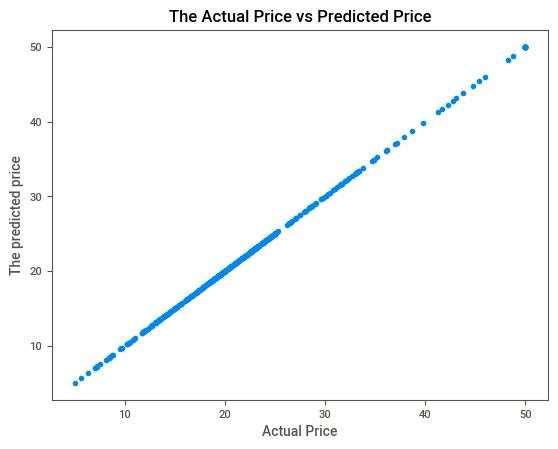

In [38]:
plt.scatter(y_train,y_pred)
plt.xlabel("Actual Price")
plt.ylabel("The predicted price")
plt.title("The Actual Price vs Predicted Price")

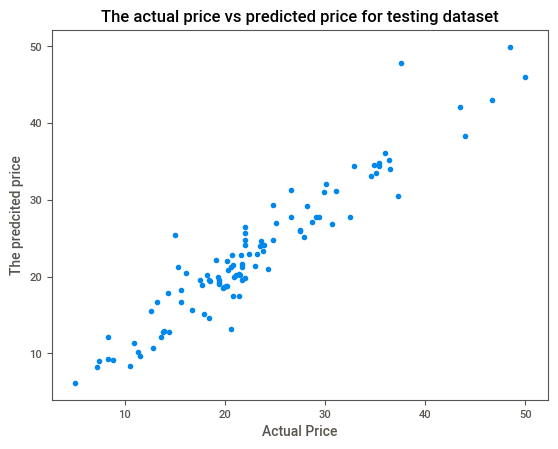

In [40]:
plt.scatter(y_test,y_pred1)
plt.xlabel("Actual Price")
plt.ylabel("The predcited price")
plt.title("The actual price vs predicted price for testing dataset")
plt.show()